### Imports

In [2]:
#Handle imports
import csv 
import sys
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn import svm  
from sklearn.svm import SVC 
from sklearn.linear_model import LogisticRegression  
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

### Data Preparation ###

In [3]:
#Read csv
training = np.genfromtxt('training.csv', delimiter=',')
#Delete top row
training = np.delete(training, 0,axis=0)
#Delete left row, operations are the same for add training and testing
training = np.delete(training, 0, axis=1)
addtraining = np.genfromtxt('additional_training.csv', delimiter=',')
addtraining = np.delete(addtraining, 0,axis=0)
addtraining = np.delete(addtraining, 0, axis=1)
testing = np.genfromtxt('testing.csv', delimiter=',')
testing = np.delete(testing, 0,axis=0)
testing = np.delete(testing, 0, axis=1)

#Combine training and additional training
training = np.concatenate((training, addtraining))
#Extract the labels
labels = training[:, -1] 
#Delete the labels
training = np.delete(training, -1, axis=1)

### Pre-processing ###

In [4]:
#Impute missing values
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
training = imp.fit_transform(training)
#Standardize Data to fit training
scaler = preprocessing.StandardScaler().fit(training)
training = scaler.transform(training)
testing = scaler.transform(testing)
#Binarizr Data to fit training
binarizer = preprocessing.Binarizer(threshold = 0.45).fit(training)
training = binarizer.transform(training)
testing = binarizer.transform(testing)
#Prepare splits for cross validation and graphing
X_train, X_test, y_train, y_test = train_test_split(training, labels, random_state=5, test_size=0.2)

### Paramater optimisation for Support Vector Machines ###

In [231]:
#Define C values to test
Cs = [0.001, 0.01, 0.1, 1, 10]
#Define gamma values to test
gammas = [0.001, 0.01, 0.1, 1]
param_grid = {'C': Cs, 'gamma' : gammas}
#Start grid search
grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid)
grid_search.fit(training, labels)
#Output
print(grid_search.best_params_)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in v

{'C': 1}


### Classification with Suport Vector Machines ###

In [5]:
#Train SVM Classifier
SVM = svm.SVC(class_weight = {1:0.3, 0:0.7}, gamma='auto').fit(training, labels)
prediction = SVM.predict(testing)  

### Classification with Logistic Regression ###

In [130]:
#Train LR Classifier
LR = LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr').fit(training, labels)  
prediction = LR.predict(testing)  

### Classification with Neural Networks ### 

In [110]:
#Train NN Classifier
NN = MLPClassifier().fit(training, labels)  
prediction = NN.predict(testing)  

### CSV Out

In [6]:
#Create ID List
idList = list(range(1, 2819))
#Convert predictions
predictionsArray = prediction.tolist()
#Insert Headers
predictionsArray.insert(0,'prediction')
idList.insert(0,'id')
#Convert to numpy
outid = np.asarray(idList)
outpred = np.asarray(predictionsArray)
#Cutput
out = np.column_stack((outid,outpred))
np.savetxt("169414.csv", out, delimiter=",",fmt='%s')

### Graphing ###

##### LEARNING_CURVE #####

/anaconda3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


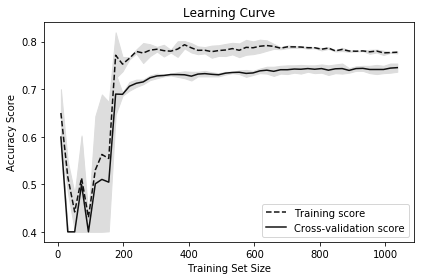

In [242]:
#Produce a learning curve graph -  @sklearn 
train_sizes, train_scores, test_scores = learning_curve(svm.SVC(kernel='rbf'), 
X_train, y_train, shuffle='true',cv=2,scoring='accuracy',train_sizes=np.linspace(0.01, 1.0, 50))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.title("Learning Curve")
plt.xlabel("Training Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

##### ROC_CURVE #####

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


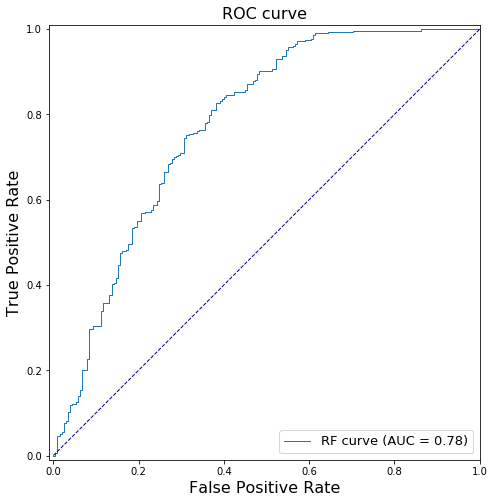

In [188]:
#Produce a ROC_Curve - @sklearn 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

y_score_rf = SVM.predict_proba(X_test)[:,-1]

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_score_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.figure(figsize=(8,8))
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_rf, tpr_rf, lw=1, label='{} curve (AUC = {:0.2f})'.format('RF',roc_auc_rf))

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC Curve', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

### Testing

In [ ]:
#Run cross validation
#SVM = svm.SVC(C=1, class_weight = {1:0.4, 0:0.6} ).fit(X_train, y_train)
#prediction = SVM.predict(X_test)  
#y_score_rf = SVM.predict_proba(testing)[:,-1]
#scores = cross_val_score(SVM, X_test, y_test, cv=5)
#print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
#print(np.count_nonzero(y_train))
#print(np.size(y_train))